In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-1]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from scipy.stats import lognorm
import os

In [2]:
n_s = 0.1

# sigma_theta_x = theta_rad/8
# sigma_theta_y = theta_rad/8

In [4]:
zenith_angle_rad = np.radians(60)

slant_distance = compute_slant_distance(h_s, h_OGS, zenith_angle_rad)

w_L = slant_distance * theta_rad

sigma_x = sigma_theta_x * slant_distance

sigma_y = sigma_theta_y * slant_distance

w_Leq_squared = equivalent_beam_width_squared(a, w_L)
w_Leq = np.sqrt(w_Leq_squared)

sigma_mod = compute_sigma_mod(mu_x, mu_y, sigma_x, sigma_y)

varphi_mod = sigma_to_variance(sigma_mod, w_Leq)

sigma_R_squared = rytov_variance(
    wavelength, zenith_angle_rad, h_OGS, h_atm, Cn2_profile)

tau_zen = 0.91

In [5]:
print(h_s)

550000


In [6]:
eta = np.arange(0, 0.05, 0.0001)

pdf_theory = np.zeros(len(eta))

In [7]:
for idx in range(len(eta)):
    pdf_theory[idx] = transmitivity_pdf(
        eta[idx], mu_x, mu_y, sigma_x, sigma_y, zenith_angle_rad,
        w_L, w_Leq, tau_zen, varphi_mod, wavelength, h_OGS,
        h_atm, Cn2_profile, a)

/home/ccl/code/04_2025_Yudai_code_check/libs/qchannel_model.py:24: RuntimeWarning: divide by zero encountered in log
  (np.log(eta / (A_mod * eta_l)) + mu)


In [8]:
def rvs_LN_fading(sigma_R_squared, size=1):
    shape_param = np.sqrt(sigma_R_squared)
    # I_a_random = lognorm.rvs(shape_param, loc=-sigma_R_squared/2, size=size)
    I_a_random = np.random.lognormal(mean=-sigma_R_squared/2, sigma=shape_param, size=size)

    return I_a_random

def rvs_pointing_err(
        mu_x, mu_y, sigma_theta_x, sigma_theta_y,
        slant_distance, theta_rad, a, w_Leq_squared, size=1):
    sigma_x = sigma_theta_x * slant_distance
    sigma_y = sigma_theta_y * slant_distance

    x = np.random.normal(loc=mu_x, scale=sigma_x, size=size)
    y = np.random.normal(loc=mu_y, scale=sigma_y, size=size)

    r = np.sqrt(x**2 + y**2)

    w_L = slant_distance * theta_rad
    nu = (np.sqrt(np.pi) * a) / (np.sqrt(2) * w_L)
    A0 = erf(nu)**2
    eta_p = A0 * np.exp(-(2*r**2)/(w_Leq_squared))

    return eta_p

In [9]:
eta_ell = compute_atm_loss(tau_zen, zenith_angle_rad)
I_a = rvs_LN_fading(sigma_R_squared, size=100000)
eta_p = rvs_pointing_err(
    mu_x, mu_y, sigma_theta_x, sigma_theta_y,
    slant_distance, theta_rad, a, w_Leq_squared,size=100000
    )
eta_simul = eta_ell * I_a * eta_p

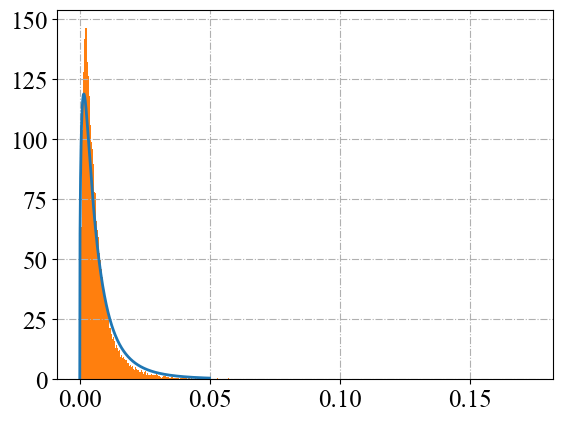

In [10]:
plt.plot(eta, pdf_theory)
plt.hist(eta_simul, density=True, bins=1000)

# plt.xlim(0, 0.05)

plt.grid()

In [11]:
qber_theory, _ = compute_avg_qber(
    sigma_theta_x, sigma_theta_y, slant_distance, mu_x, mu_y,
    zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
    a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
)
print(qber_theory)

0.09321310557026541


In [12]:
qber_simul = 0
for idx in range(np.size(eta_simul)):
    qber_simul += qber_loss(e_0, p_dark, e_pol, p_AP, eta_simul[idx], n_s)
print(qber_simul/np.size(eta_simul))

0.13806612042423838
